# Mean profiles from CNV files

In [44]:
import unisacsi.Ocean as Oc
#import unisacsi.Meteo as Met
#from unisacsi.MET_model_download import download_MET_model_static_fields, download_MET_model_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import gsw
import cmocean as cmo
import scipy.interpolate as interp

plt.rcParams["font.family"] = "times new roman"

In [45]:
def compute_mean(CTD, variable, stationnames):
    CTD_i,Z,_,_ = Oc.CTD_to_grid(CTD, stationnames,interp_opt=0)
    df = pd.DataFrame(CTD_i[variable],index=Z
                    ,columns=stationnames
                   )
    df = df[1:]
    df_mean = df.mean(axis=1)
    
    return df, df_mean

In [46]:
def plot_profiles(df, df_mean, ax):
    ax.plot(df, df.index, color='Gray', alpha=.5)
    ax.plot(df_mean, df_mean.index, lw=2)

    ax.invert_yaxis()

In [47]:
def smooth_profile(df_mean, mld, window=5):
    mixed = df_mean[:mld].mean()
    df_smooth = df_mean.rolling(window=window, center=True).mean()
    
    df_smooth[:mld] = mixed
    
    return df_smooth

In [48]:
def create_initial_ocean(depth, T_mean, S_mean, depth_new):
    interpolater = interp.interp1d(depth, T_mean, fill_value = "extrapolate")
    T_new = interpolater(depth_new)
    
    interpolater = interp.interp1d(depth, S_mean, fill_value = "extrapolate")
    S_new = interpolater(depth_new)

    data = {'depth': depth_new, 'temp':T_new, 'salinity':S_new}
    dataFrame = pd.DataFrame(data)
    return dataFrame

In [86]:
# path to cnv-files. Should be on the format Sta0001.cnv (Sta followed by four digits)
path_data = '../../data/CTD/Adventfjorden/221103/'

In [87]:
# Read in files
CTD = Oc.read_CTD(path_data)

day2day_comp = ['A2','A4','A5','A6','A7','A9','A13','A15']
stations = [f'{i}' for i in CTD.keys()]
#stations = day2day_comp


In [18]:
# print(CTD[stations[0]].keys()) # displays variables saved at first (each) station

dict_keys(['P', 'T', 'C', 'OX', 'S', 'SIGTH', 'Cs', 'sbe_model', 'gps_datetime', 'seasave', 'instrument_type', 'nquan', 'nvalues', 'start_time', 'bad_flag', 'file_type', 'md5', 'datetime', 'filename', 'dnum', 'LAT', 'LON', 'z', 'BottomDepth', 'SA', 'CT', 'st', 'unis_st'])


3.575
3.5724201992566056


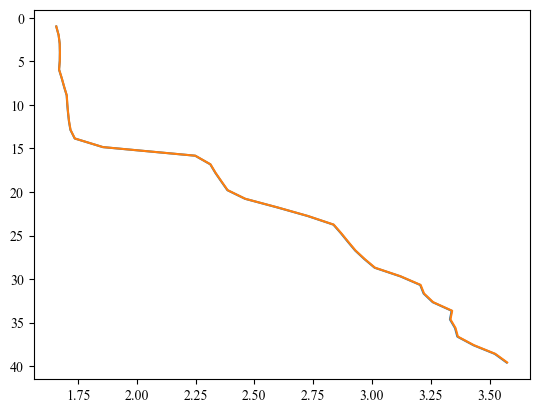

In [51]:
# Converting in-situ temperature to potential temperature 

for station in stations:
    T = CTD[station]['T']
    S = CTD[station]['S']
    P = CTD[station]['P']
    z = CTD[station]['z']
    
    # calculate potential temperature
    PT = gsw.conversions.pt0_from_t(S, T, P)
    CTD[station]['PT'] = PT


print(T[-1])
print(PT[-1])
plt.figure()
plt.plot(PT,-z)
plt.plot(T,-z)
plt.gca().invert_yaxis()

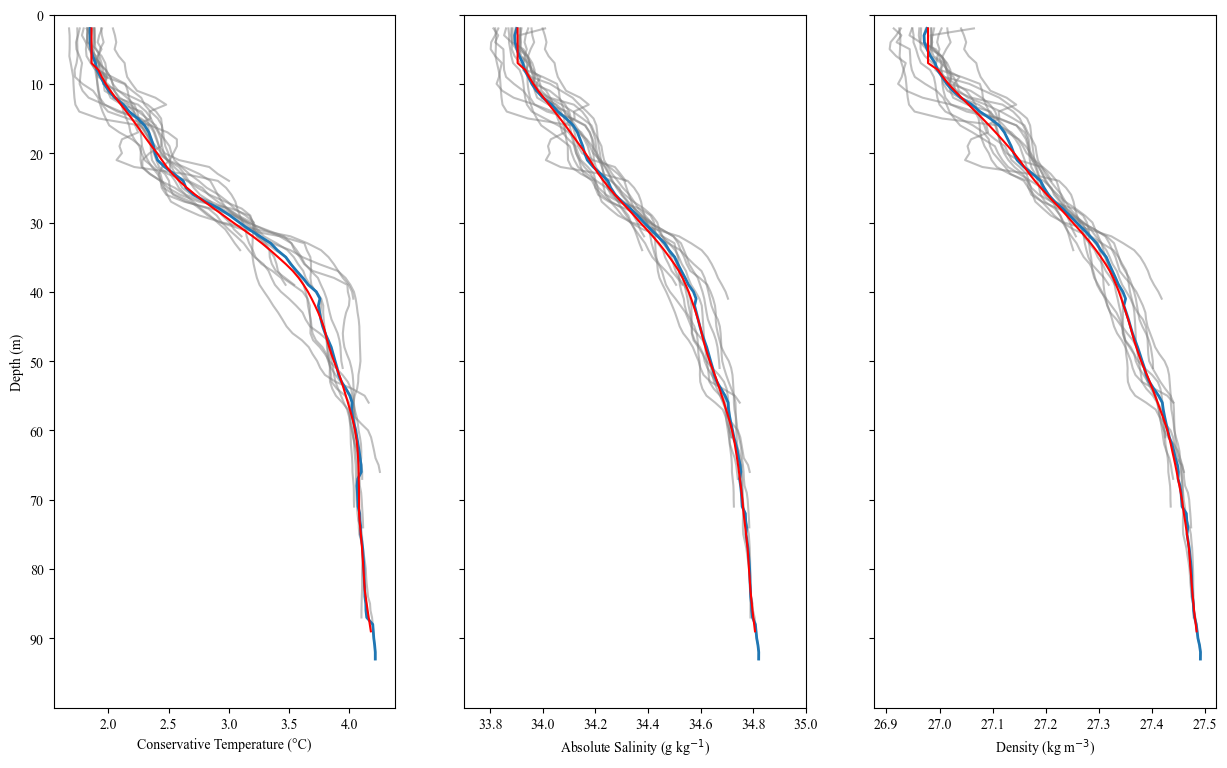

In [92]:
window = 10
mld=7

dfT, dfT_mean = compute_mean(CTD, 'CT', stations)
dfS, dfS_mean = compute_mean(CTD, 'SA', stations)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', stations)

dfT_smooth = smooth_profile(dfT_mean, mld, window)
dfS_smooth = smooth_profile(dfS_mean, mld, window)
dfs_smooth = smooth_profile(dfs_mean, mld, window)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)

axT.plot(dfT_smooth, dfT_smooth.index, color='red')
axS.plot(dfS_smooth, dfs_smooth.index, color='red')
axs.plot(dfs_smooth, dfs_smooth.index, color='red')
axT.set_ylabel('Depth (m)')
axT.set_xlabel('Conservative Temperature (\N{DEGREE SIGN}C)')
axS.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
axs.set_xlabel('Density (kg m$^{-3}$)')
axs.yaxis.set_ticks(np.arange(0, 100, 10))
axs.set_ylim([100,0])
axS.set_xlim([33.7, 35])
plt.savefig("../../ocean_plots/meanprofiles_221103.png",bbox_inches = "tight", dpi = 300)

In [62]:
dfT_smooth

1.989480     1.854287
2.989484     1.854287
3.989488     1.854287
4.989491     1.854287
5.989495     1.854287
               ...   
88.989799    4.189041
89.989802         NaN
90.989806         NaN
91.989810         NaN
92.989813         NaN
Length: 92, dtype: float64

In [57]:
dfT_smooth.values[0]

1.854287326535264

In [53]:
# create file with initial ocean conditions (depth, meanT, meanS)
model_depth = np.arange(0,round(dfT_smooth.index[-1]),0.5)

dataFrame = create_initial_ocean(dfT_smooth.index, dfT_smooth.values, dfS_smooth.values, model_depth)
#print(dataFrame)
dataFrame.to_csv("../../data/CTD_processed/NEWmean_profile_221103_mld_7_res_05.csv")

## DAY 1

In [93]:
path_data = '../../data/CTD/Adventfjorden/221031/'
# Read in files
CTD = Oc.read_CTD(path_data)
day2day_comp = ['A2','A9','A13','A15','322','993','323','324']

stations = [f'{i}' for i in CTD.keys()]
#stations = day2day_comp

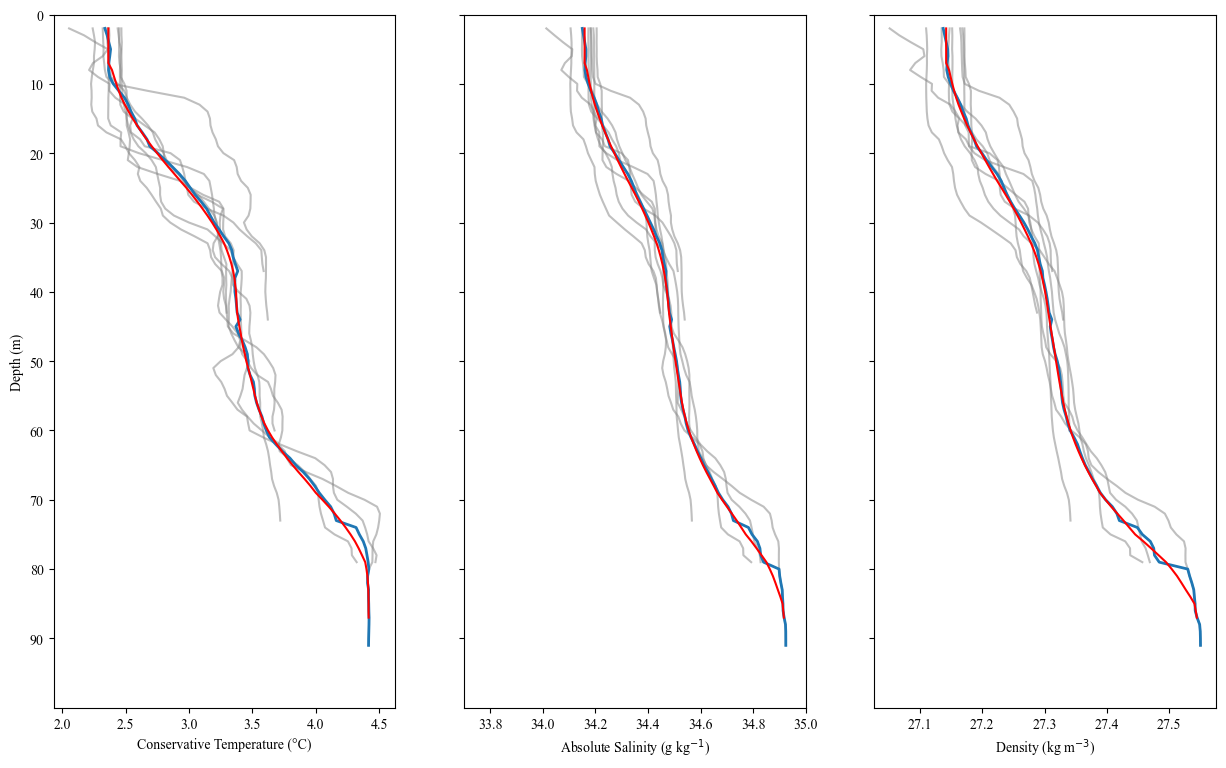

In [94]:
dfT, dfT_mean = compute_mean(CTD, 'CT', stations)
dfS, dfS_mean = compute_mean(CTD, 'SA', stations)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', stations)

dfT_smooth = smooth_profile(dfT_mean, mld, window)
dfS_smooth = smooth_profile(dfS_mean, mld, window)
dfs_smooth = smooth_profile(dfs_mean, mld, window)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)

axT.plot(dfT_smooth, dfT_smooth.index, color='red')
axS.plot(dfS_smooth, dfs_smooth.index, color='red')
axs.plot(dfs_smooth, dfs_smooth.index, color='red')
axT.set_ylabel('Depth (m)')
axT.set_xlabel('Conservative Temperature (\N{DEGREE SIGN}C)')
axS.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
axs.set_xlabel('Density (kg m$^{-3}$)')
axs.yaxis.set_ticks(np.arange(0, 100, 10))
axs.set_ylim([100,0])
axS.set_xlim([33.7, 35])
plt.savefig("../../ocean_plots/meanprofiles_221031.png",bbox_inches = "tight", dpi = 300)

In [26]:
# create file with initial ocean conditions (depth, meanT, meanS)
model_depth = np.arange(0,round(dfT_smooth.index[-1]),0.5)
dataFrame = create_initial_ocean(dfT_smooth.index, dfT_smooth.values, dfS_smooth.values, model_depth)
#print(dataFrame)
dataFrame.to_csv("../../data/CTD_processed/NEWmean_profile_221031_mld_7_res_05.csv")

## INTERNAL ROSSBY RADIUS

R = c/f; c = sqrt(g (Delta_rho/rho2) ((H1*H2)/(H1+H2)) 

density profile for cross sections from each day - split up in two density layers.
doesn't really matter for ice growth (maybe slightly influences the distribution), but Ekman transport dominates.

(26.9, 27.5)

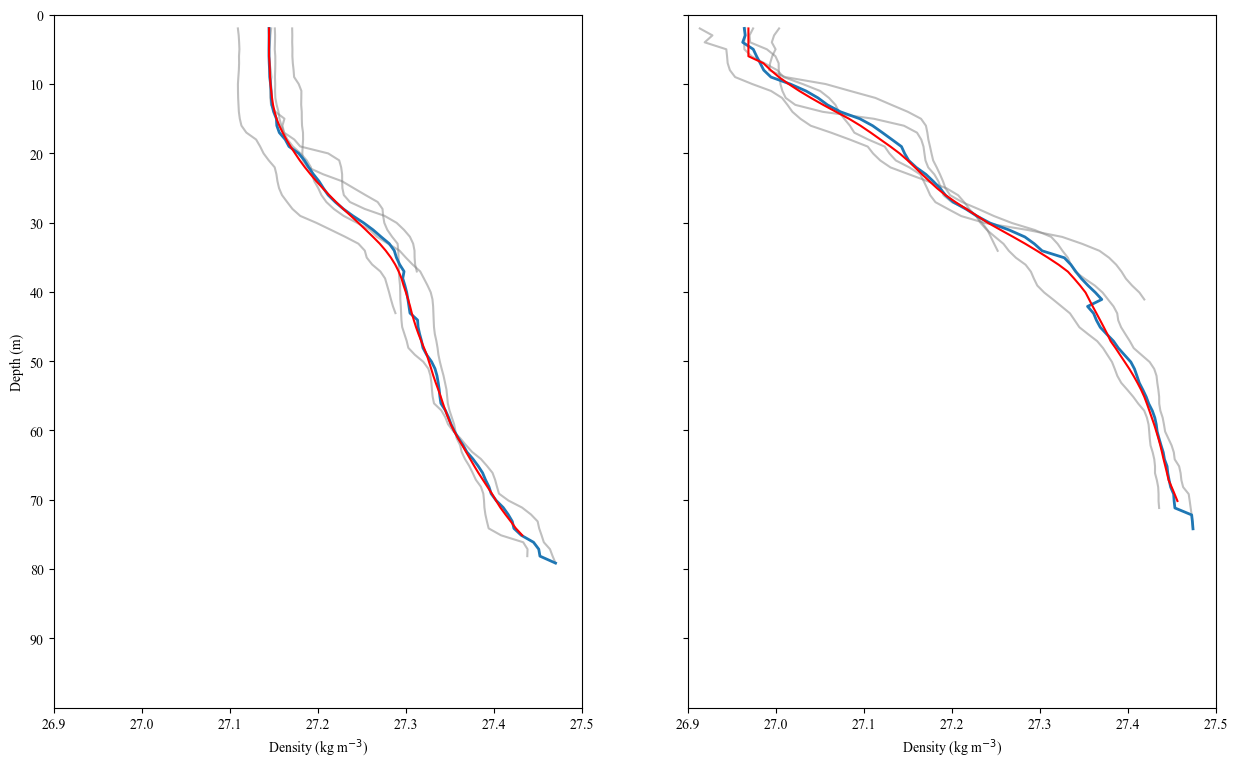

In [72]:
path_data1 = '../../data/CTD/Adventfjorden/221031/'
path_data2 = '../../data/CTD/Adventfjorden/221103/'

CTD1 = Oc.read_CTD(path_data1)
CTD2 = Oc.read_CTD(path_data2)

adv_cross1 = ['322', '993', '323', '324'] 
adv_cross2 = ['A4', 'A5', 'A6', 'A7'] # Station Names second day (03/11/22)

dfs1, dfs_mean1 = compute_mean(CTD1, 'SIGTH', adv_cross1)
dfs2, dfs_mean2 = compute_mean(CTD2, 'SIGTH', adv_cross2)
dfs_smooth1 = smooth_profile(dfs_mean1, mld, window)
dfs_smooth2 = smooth_profile(dfs_mean2, mld, window)

fig, [axs1, axs2] = plt.subplots(1,2, sharey=True, figsize=(15,9))
plot_profiles(dfs1, dfs_mean1, axs1)
plot_profiles(dfs2, dfs_mean2, axs2)
axs1.plot(dfs_smooth1, dfs_smooth1.index, color='red')
axs2.plot(dfs_smooth2, dfs_smooth2.index, color='red')
axs1.set_ylabel('Depth (m)')
axs1.set_xlabel('Density (kg m$^{-3}$)')
axs2.set_xlabel('Density (kg m$^{-3}$)')
axs1.yaxis.set_ticks(np.arange(0, 100, 10))
axs1.set_ylim([100,0])
axs2.yaxis.set_ticks(np.arange(0, 100, 10))
axs2.set_ylim([100,0])
#axs1.set_xlim([26.9,27.5])
#axs2.set_xlim([26.9,27.5])
